<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Performance Profiling of Validation Simulations

In [103]:
import pandas as pd
from typing import Any
import matplotlib.pyplot as plt

In [9]:
from pathlib import Path
import os

In [3]:
gpu_profile_dir = Path("../profiles")

In [4]:
line_profile_dir = Path("../profiling")

In [5]:
line_profile_dir.exists()

True

In [6]:
import sys

In [7]:
sys.path.append("..")

In [10]:
os.environ['VALIDATION_SYSTEM_NAME'] = "NRAO"

In [13]:
from core.utils import ANTS_DICT

In [28]:
def parse_profiling_fname(fname: str) -> dict[str, Any]:
    if not fname.endswith("profile.txt"):
        raise ValueError(f"fname {fname} doesn't end with .profile.txt")
    
    parts = fname.replace(".profile.txt", "").split("-")
    sky, gpu, nt, layout, mv, hs = parts
    nside = int(sky[5:])  # only works for ptsrc!!
    gpu = 'True' in gpu
    ntimes = 17280 // int(nt[2:])
    nant = len(ANTS_DICT[layout])
    
    return {
        'nside': nside,
        'gpu': gpu,
        'ntimes': ntimes,
        'nant': nant,
        'layout': layout,
        'matvis version': mv[2:],
        'hera_sim version': hs[2:],
        'sky': sky
    }
    

In [75]:
def parse_timing_line(line: str):
    parts = line.split()
    line_number, nhits, t, t_per_hit, percent = parts[:5]
    contents = parts[5] + line.split(parts[5])[-1]
    #print(line, parts[:5], contents)
    return int(line_number), int(nhits), float(t), float(t_per_hit), float(percent), contents

def get_lineprof(fname):
    """We don't trust any of the line profiling times for GPU code calls, because they're not synced.
    
    To get timings for each step, we need the GPU profiling tools.
    """
    with open(fname, 'r') as fl:
        lines = fl.readlines()
        
    total_time = 0
    sim_time = 0
    setup_time = 0
    writeout_time = 0
    sim_nonloop_time = 0
    sim_loop_time = 0
    
    in_run_vis_sim = False
    in_simulate = False
    before_simulate = True
    in_time_loop = False
    for line in lines:
        
        if "Total time:" in line:
            # Each function has a total time -- we get the longest one as probably the 'outer' one
            total_time = max(total_time, float(line.split(":")[-1].split(" s")[0]))
                    
        if "def run_vis_sim" in line:
            in_run_vis_sim = True
        if "def simulate" in line:
            in_simulate = True
            
        if line.startswith("======================="):
            in_run_vis_sim = False
            in_simulate = False
        
        try:
            # if the line doesn't parse, just ignore it, it's not a code line
            _, _, t, _, _, contents = parse_timing_line(line)
        except Exception as e:
            #print(e)
            continue

        if "simulation.simulate()" in contents:
            before_simulate = False
            sim_time = t
        elif in_run_vis_sim and not before_simulate:
            writeout_time += t
            
        if before_simulate and in_run_vis_sim:
            setup_time += t
            
        if "for t in range(ntimes):" in contents:
            in_time_loop = True
        if "cublasDestroy(h)" in contents:
            in_time_loop = False
        
        if in_simulate and not in_time_loop:
            sim_nonloop_time += t
        if in_simulate and in_time_loop:
            sim_loop_time += t
            
    return {
        'total_time': total_time,
        'sim_time': sim_time*1e-9,
        'setup_time': setup_time*1e-9,
        'write_time':writeout_time*1e-9,
        'nonloop_time': sim_nonloop_time*1e-9,
        'loop_time': sim_loop_time*1e-9,
    }

In [89]:
all_files = sorted(line_profile_dir.glob("*.profile.txt"))

all_params = []
for fl in all_files:
    params = parse_profiling_fname(fl.name)
    if params['hera_sim version'] != "4.2.1.dev7+g16673cb":
        continue
    timings = get_lineprof(fl)
    all_params.append({**params, **timings})
    

In [90]:
sim_table = pd.DataFrame(all_params)

In [91]:
sim_table['nsources'] = 12*sim_table['nside']**2

In [92]:
# Probable H6C parameters

nant_norm = 320
ntime_norm = 720
nside_norm = 512

In [93]:
sim_table['nant_norm'] = sim_table['nant']/nant_norm
sim_table['ntimes_norm'] = sim_table['ntimes']/ntime_norm
sim_table['nsources_norm'] = sim_table['nsources']/(12 * nside_norm**2)

# Different things we could scale with
sim_table['bls'] = sim_table['nant']**2
sim_table['bls_norm'] = sim_table['nant_norm']**2

sim_table['blts'] = sim_table['bls']*sim_table['ntimes']
sim_table['blts_norm'] = sim_table['bls_norm'] * sim_table['ntimes_norm']
sim_table['ant_times'] = sim_table['nant'] * sim_table['ntimes']
sim_table['ant_times_norm'] = sim_table['nant_norm'] * sim_table['ntimes_norm']

sim_table['blts x nsource'] = sim_table['blts'] * sim_table['nsources']
sim_table['blts x nsource norm'] = sim_table['blts_norm'] * sim_table['nsources_norm']

sim_table['nant x ntime x nsource'] = sim_table['ant_times'] * sim_table['nsources']
sim_table['nant x ntime x nsource norm'] = sim_table['ant_times_norm'] * sim_table['nsources_norm']



In [94]:
sim_table

,nside,gpu,ntimes,nant,layout,matvis version,hera_sim version,sky,total_time,sim_time,...,bls,bls_norm,blts,blts_norm,ant_times,ant_times_norm,blts x nsource,blts x nsource norm,nant x ntime x nsource,nant x ntime x nsource norm
0,128,True,720,350,FULL,1.2.1,4.2.1.dev7+g16673cb,ptsrc128,356.484,200.0,...,122500,1.196289,88200000,1.196289,252000,1.093750,17340825600000,0.074768,49545216000,0.068359
1,128,True,720,126,H4C,1.2.1,4.2.1.dev7+g16673cb,ptsrc128,370.428,200.0,...,15876,0.155039,11430720,0.155039,90720,0.393750,2247370997760,0.009690,17836277760,0.024609
2,128,True,720,320,HEX,1.2.1,4.2.1.dev7+g16673cb,ptsrc128,298.646,200.0,...,102400,1.000000,73728000,1.000000,230400,1.000000,14495514624000,0.062500,45298483200,0.062500
3,128,True,480,350,FULL,1.2.1,4.2.1.dev7+g16673cb,ptsrc128,232.301,100.0,...,122500,1.196289,58800000,0.797526,168000,0.729167,11560550400000,0.049845,33030144000,0.045573
4,128,True,480,126,H4C,1.2.1,4.2.1.dev7+g16673cb,ptsrc128,243.352,100.0,...,15876,0.155039,7620480,0.103359,60480,0.262500,1498247331840,0.006460,11890851840,0.016406
5,128,True,480,320,HEX,1.2.1,4.2.1.dev7+g16673cb,ptsrc128,193.072,100.0,...,102400,1.000000,49152000,0.666667,153600,0.666667,9663676416000,0.041667,30198988800,0.041667
6,256,True,720,350,FULL,1.2.1,4.2.1.dev7+g16673cb,ptsrc256,671.948,500.0,...,122500,1.196289,88200000,1.196289,252000,1.093750,69363302400000,0.299072,198180864000,0.273438
7,256,True,720,126,H4C,1.2.1,4.2.1.dev7+g16673cb,ptsrc256,575.717,400.0,...,15876,0.155039,11430720,0.155039,90720,0.393750,8989483991040,0.038760,71345111040,0.098437
8,256,True,720,320,HEX,1.2.1,4.2.1.dev7+g16673cb,ptsrc256,561.021,400.0,...,102400,1.000000,73728000,1.000000,230400,1.000000,57982058496000,0.250000,181193932800,0.250000
9,256,True,480,350,FULL,1.2.1,4.2.1.dev7+g16673cb,ptsrc256,438.570,300.0,...,122500,1.196289,58800000,0.797526,168000,0.729167,46242201600000,0.199382,132120576000,0.182292


In [99]:
sim_table['loop_time']

0     116.556977
1     119.073453
2      96.724380
3      79.137094
4      82.085435
5      68.287639
6     375.659646
7     383.941201
8     369.685855
9     256.178978
10    256.470046
11    255.498038
12    229.687291
13    192.388976
Name: loop_time, dtype: float64

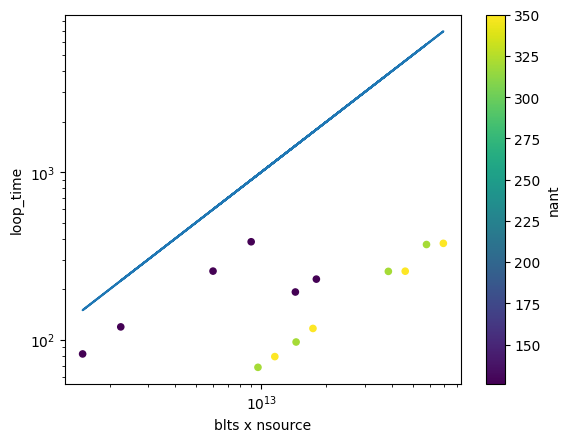

In [104]:
sim_table.plot.scatter("blts x nsource", "loop_time", c='nant', cmap='viridis', loglog=True)
plt.plot(sim_table['blts x nsource'], 1e-10* sim_table['blts x nsource'])

<AxesSubplot: xlabel='nant x ntime x nsource', ylabel='loop_time'>

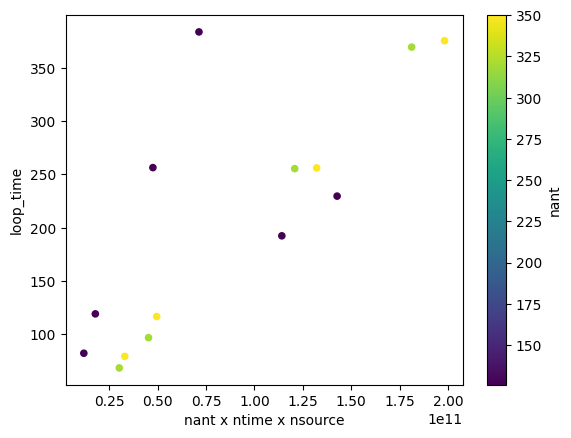

In [100]:
sim_table.plot.scatter("nant x ntime x nsource", "loop_time", c='nant', cmap='viridis')

In [74]:
get_lineprof(all_files[0])

{'total_time': 356.484,
 'sim_time': 200.0,
 'setup_time': 203.202899481,
 'write_time': 2.1239412420000003,
 'nonloop_time': 3.7304594910000004,
 'loop_time': 116.556976574}